In [1]:
from __future__ import division

import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

### Load the game environment

In [2]:
from environment import ConnectFourEnvironment

env = ConnectFourEnvironment()

### Implementing the network itself

In [3]:
class Qnetwork():
    def __init__(self,h_size):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,7*6*2],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,7,6,2])
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[4,4],stride=[1,1],padding='SAME', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='SAME', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[2,2],stride=[1,1],padding='SAME', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,6],stride=[1,1],padding='VALID', biases_initializer=None)
        
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.actions]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

This is a simple function to resize our game frames.

In [4]:
def processState(states):
    return np.reshape(states,[7*6*2])

### Validating the network

Setting all the validation parameters

In [5]:
play_level = 2
num_episodes = 1000 #How many episodes of game environment to train network with.
max_epLength = 50 #The max allowed length of our episode.
path = "./dqn" #The path to save our model to.
h_size = 14 #The size of the final convolutional layer before splitting it into Advantage and Value streams.

In [8]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

env.play_level = play_level
# validation reward system
env.reward_rules_only(True)

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    print('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(path)
    saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        s = processState(env.state)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 50 moves to reach either of the blocks, end the trial.
            j+=1
            a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            r = env.step(a)
            s1 = processState(env.state)
            d = env.terminated
            total_steps += 1
            rAll += r
            s = s1
            
            if d == True:
                break
        
        jList.append(j)
        rList.append(rAll)
        if len(rList) % 10 == 0:
            print(i, j, np.mean(rList[-10:]))
print("Percent of succesful episodes: " + str(100 * sum(rList)/num_episodes) + "%")

Loading Model...
INFO:tensorflow:Restoring parameters from ./dqn/model-199999.ckpt
9 7 0.7
19 10 0.7
29 8 0.6
39 11 0.7
49 10 0.3
59 15 0.5
69 11 0.2
79 12 0.5
89 6 0.5
99 12 0.7
109 11 0.5
119 11 0.7
129 6 0.7
139 10 0.6
149 13 0.7
159 8 0.7
169 7 0.5
179 9 0.4
189 13 0.5
199 5 0.4
209 10 0.5
219 7 0.9
229 14 0.8
239 5 0.5
249 12 0.7
259 7 0.4
269 9 0.9
279 13 0.4
289 11 0.7
299 9 0.6
309 15 0.4
319 9 0.8
329 14 0.4
339 5 0.5
349 4 0.5
359 12 0.4
369 6 0.7
379 11 0.6
389 12 0.7
399 11 0.6
409 10 0.7
419 16 0.5
429 13 0.5
439 11 0.5
449 13 0.8
459 10 0.7
469 12 0.9
479 6 0.4
489 14 0.6
499 9 0.8
509 9 0.9
519 9 0.5
529 10 0.5
539 14 0.4
549 10 0.5
559 11 0.6
569 8 0.7
579 11 0.6
589 9 0.5
599 10 0.7
609 11 0.3
619 5 0.5
629 6 0.6
639 13 0.3
649 14 0.5
659 15 0.7
669 5 0.7
679 7 0.6
689 9 0.4
699 14 0.4
709 11 0.5
719 11 0.6
729 12 0.6
739 7 0.3
749 6 0.8
759 9 0.7
769 10 0.7
779 16 0.7
789 6 0.6
799 13 0.6
809 5 0.6
819 11 0.5
829 12 0.7
839 16 0.5
849 4 0.7
859 6 0.3
869 8 0.6
879 15 

### Checking network learning

Mean reward over time

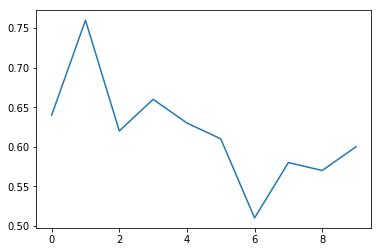

In [7]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)